<a href="https://colab.research.google.com/github/RahadianSurya/Transfer-Learning/blob/main/Part_4_Transfer_Learning_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install jcopdl==1.1.1 --quiet

In [3]:
import jcopdl
import matplotlib.pyplot as plt
import numpy as np

In [4]:
!unzip /content/drive/MyDrive/data/data.zip 

Archive:  /content/drive/MyDrive/data/data.zip
replace data/test_label.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/test_label.csv     
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/test/1409.jpg      
  inflating: __MACOSX/data/test/._1409.jpg  
  inflating: data/test/1347.jpg      
  inflating: __MACOSX/data/test/._1347.jpg  
  inflating: data/test/1145.jpg      
  inflating: __MACOSX/data/test/._1145.jpg  
  inflating: data/test/360.jpg       
  inflating: __MACOSX/data/test/._360.jpg  
  inflating: data/test/1192.jpg      
  inflating: __MACOSX/data/test/._1192.jpg  
  inflating: data/test/374.jpg       
  inflating: __MACOSX/data/test/._374.jpg  
  inflating: data/test/1964.jpg      
  inflating: __MACOSX/data/test/._1964.jpg  
  inflating: data/test/195

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Dataset & Dataloader

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [7]:
from jcopdl.utils.dataloader import MultilabelDataset

In [8]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size,scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229,0.224,0.225])    
])

train_set = MultilabelDataset(csv_path='data/train_label.csv',
                              img_path='data/train/',
                              fname_col='fname',
                              transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=0)

test_set = MultilabelDataset(csv_path='data/test_label.csv',
                                img_path='data/test/',
                                fname_col='fname',
                                transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [9]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

### Arsitektur & Config

In [10]:
from torchvision.models import mobilenet_v2

In [11]:
mnet = mobilenet_v2(progress=True,weights='MobileNet_V2_Weights.DEFAULT')

for param in mnet.parameters():
    param.requires_grad = False

In [12]:
#mnet

In [13]:
mnet.classifier = nn.Sequential(
                    nn.Linear(1280, 5),
                    nn.Sigmoid(),
)

In [14]:
mnet.classifier

Sequential(
  (0): Linear(in_features=1280, out_features=5, bias=True)
  (1): Sigmoid()
)

In [15]:
class CustomMobilenet(nn.Module):
    def __init__(self,output_size):
        super().__init__()
        self.mnet = mobilenet_v2(progress=True,weights='MobileNet_V2_Weights.DEFAULT')
        self.freeze()
        self.mnet.classifier = nn.Sequential(
                    nn.Linear(1280, output_size),
                    nn.Sigmoid(),)
        
    def forward(self, x):
        return self.mnet(x)
    def freeze(self):
        for param in mnet.parameters():
            param.requires_grad = False
    def unfreeze(self):
        for param in mnet.parameters():
            param.requires_grad = True

In [16]:
config = set_config({
    "output_size": len(train_set.classes),
    "batch_size" : bs,
    "crop_size" : crop_size,
})

### Phase 1 : Adaptasi (learning rate standar + patience kecil) 

In [17]:
model = CustomMobilenet(output_size=5).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config,early_stop_patience=2, outdir="model")

In [18]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.3233 | Test_cost  = 0.2350 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1795 | Test_cost  = 0.2439 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2350


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1431 | Test_cost  = 0.2413 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2350
==> Execute Early Stopping at epoch: 3 | Best test_cost: 0.2350
==> Best model is saved at model


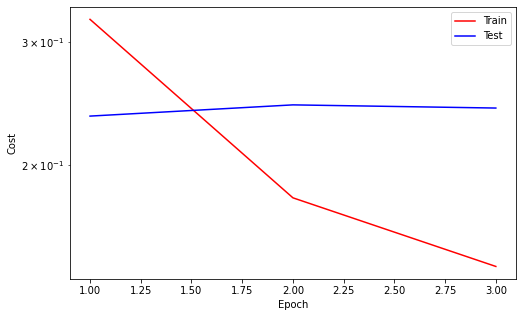

In [19]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

### Fine Tuning ( learning rate kecil + patience besar)

In [20]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
callback.reset_early_stop()
callback.early_stop_patience = 5

Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1764 | Test_cost  = 0.2045 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1601 | Test_cost  = 0.1934 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1535 | Test_cost  = 0.1843 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1514 | Test_cost  = 0.1988 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1843


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.1481 | Test_cost  = 0.1909 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1843


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1463 | Test_cost  = 0.1875 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1843


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1426 | Test_cost  = 0.1816 | 


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.1429 | Test_cost  = 0.1817 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1816


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.1382 | Test_cost  = 0.1914 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1816


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.1412 | Test_cost  = 0.1820 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1816


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.1308 | Test_cost  = 0.1886 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1816


Train:   0%|          | 0/26 [00:00<?, ?it/s]

Test:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.1340 | Test_cost  = 0.1876 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1816
==> Execute Early Stopping at epoch: 15 | Best test_cost: 0.1816
==> Best model is saved at model


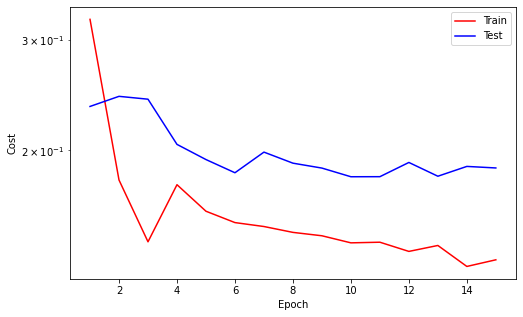

In [21]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

In [22]:
feature , target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [23]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5).to(torch.float32)
preds

tensor([[0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0

### Sanity Check

In [24]:
def convert_to_label(x):
    return [label for pred,label in zip(x,label2cat) if pred==1]

def inverse_norm(img):
    img[0,:,:] = img[0,:,:] * 0.229 + 0.485
    img[1,:,:] = img[1,:,:] * 0.224 + 0.456
    img[2,:,:] = img[2,:,:] * 0.225 + 0.406
    return img

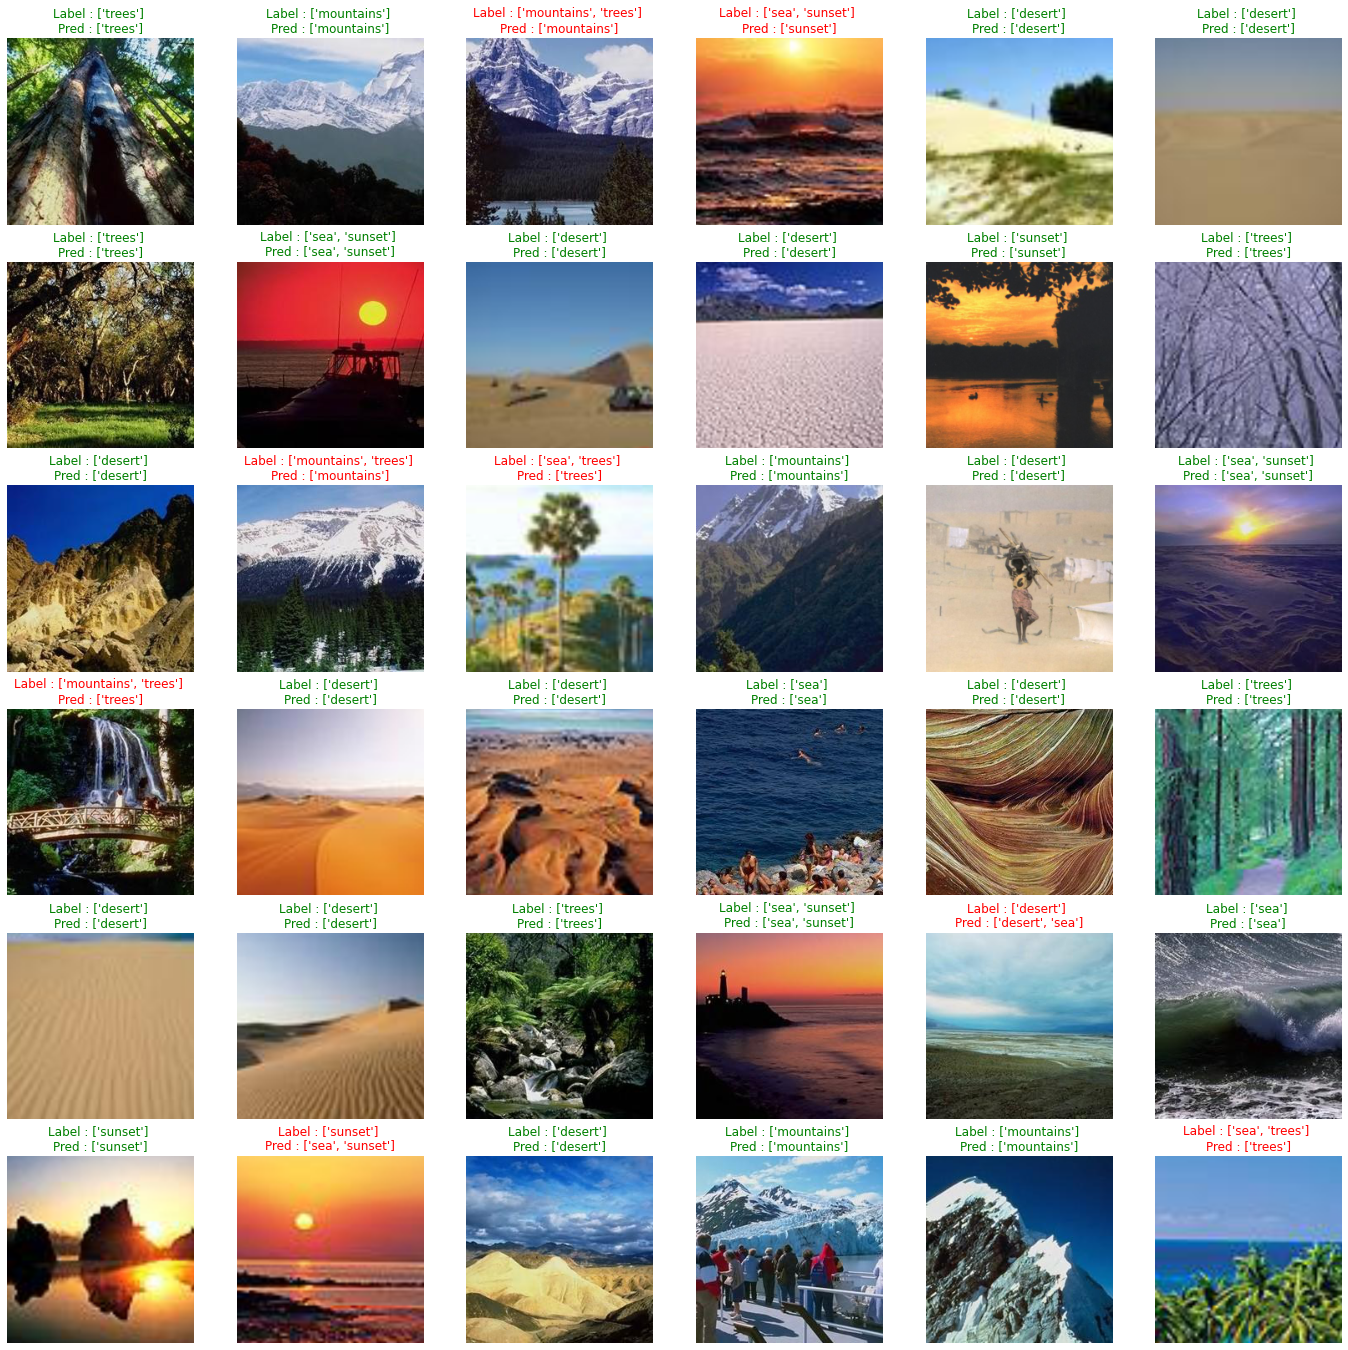

In [25]:
fig, axes = plt.subplots(6,6, figsize=(24,24))
for img, label, pred, ax in zip(feature, target, preds,axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1,2,0).cpu())
    font = {'color':'r'} if (pred != label).any() else {'color':'g'}
    label, pred = convert_to_label(label),convert_to_label(pred)
    ax.set_title(f"Label : {label} \nPred : {pred}",fontdict = font);
    ax.axis('off');